# ワクチン接種後の入院日数と入院有無を予測する機械学習モデルの構築と比較

In [1]:
# ---------------------------------------
# 基本ライブラリ
# ---------------------------------------
import os                              # ファイル操作
import zipfile                         # zipファイル操作
import numpy as np                     # 数値計算
import pandas as pd                    # データフレーム操作
import matplotlib.pyplot as plt        # グラフ描画
import shap                            # SHAP値の可視化

# ---------------------------------------
# 前処理・データ分割
# ---------------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV   # データ分割・グリッドサーチ
from sklearn.preprocessing import LabelEncoder                       # ラベルエンコード
from sklearn.preprocessing import OneHotEncoder                      # One-Hotエンコーディング
from sklearn.compose import ColumnTransformer                        # 複数の前処理をカラムごとに適用
from sklearn.pipeline import Pipeline                                # 一連の前処理とモデルをまとめて実行
from sklearn.impute import SimpleImputer                             # 欠損値補完

# ---------------------------------------
# モデル
# ---------------------------------------
from sklearn.linear_model import LinearRegression        # 線形回帰
from sklearn.ensemble import RandomForestClassifier      # ランダムフォレスト
from lightgbm import LGBMClassifier                      # LightGBM（モデル）
import lightgbm as lgb                                   # LightGBM（SHAPなどで使用）

# ---------------------------------------
# モデル評価
# ---------------------------------------
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)

C:\Users\okada\anaconda3\envs\fraud-detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. はじめに

### 1.1 目的と背景
本プロジェクトでは、ワクチン接種後の患者データを用いて、入院日数（HOSPDAYS）を予測する回帰モデル、及び入院の有無（HOSPITAL）を分類するモデルを構築した。これにより、医療機関におけるリソース配分や予後判断の一助となるデータ活用を目的とする。

### 1.2 使用データ
本分析では、2020年に米国で収集されたVAERS（Vaccine Adverse Event Reporting System）のデータを使用した。これは、ワクチン接種後に発生した有害事象を記録した公開データであり、年齢・性別・接種日・発症日・症状・既往歴など多様な情報を含む。

In [2]:
# CSVファイルの読み込み
df_data = pd.read_csv(r'C:\Users\okada\VAERS_Columns.csv')

# データの内容を表示
df_data.head(17)

,カラム名,データ型,説明
0,AGE_YRS,Num (xxx.x),年齢（単位：歳）
1,CAGE_YR,Num (xxx),年齢（年単位、計算値）
2,CAGE_MO,Num (x.x),年齢（月単位、計算値）
3,SEX,Char (1),性別（M/F/U）
4,HOSPDAYS,Num (3),入院日数
5,VAX_DATE,Date,ワクチン接種日
6,ONSET_DATE,Date,有害事象の発生日
7,NUMDAYS,Num (5),潜伏期間（日数）
8,V_ADMINBY,Char (3),ワクチン接種を実施した施設の種類
9,CUR_ILL,Char (32000),接種時の既往症や疾患


## 2. 入院日数を予測する回帰モデル
本分析では、まずシンプルな線形回帰モデルを適用した上で、非線形な関係を捉えることが可能なLightGBMを用いることで、入院日数の予測精度の向上を図った。

### 2.1 データの確認・前処理
モデル構築に先立ち、欠損値の補完、外れ値の除去、特徴量のエンジニアリング、カテゴリ変数のエンコードなどの前処理を実施した。

In [3]:
# ==========================
# ZIPファイルの解凍処理
# ==========================

# ZIPファイルのパスと展開先のディレクトリ名を定義
zip_path = 'VAERSDATA.csv.zip'
extract_dir = 'unzipped_drug_data'

# ZIPファイルの解凍処理
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 解凍後のCSVファイルのパス指定
csv_file_path = os.path.join(extract_dir, 'VAERSDATA.csv')

# CSVファイルの読み込み（dtype警告回避のため low_memory=False を指定）
df = pd.read_csv(csv_file_path, low_memory=False)

# 最初の5行を表示して内容を確認
df.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none
1,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,...,NaN,NaN,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NaN
2,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,none,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry"
3,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,...,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,Y,none
4,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,"Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,Biaxin


In [4]:
# ==========================
# データ型の確認
# ==========================

# 各列のデータ型を確認
print("各カラムのデータ型:")
print(df.dtypes)

各カラムのデータ型:
VAERS_ID          int64
RECVDATE         object
STATE            object
AGE_YRS         float64
CAGE_YR         float64
CAGE_MO         float64
SEX              object
RPT_DATE         object
SYMPTOM_TEXT     object
DIED             object
DATEDIED         object
L_THREAT         object
ER_VISIT         object
HOSPITAL         object
HOSPDAYS        float64
X_STAY           object
DISABLE          object
RECOVD           object
VAX_DATE         object
ONSET_DATE       object
NUMDAYS         float64
LAB_DATA         object
V_ADMINBY        object
V_FUNDBY         object
OTHER_MEDS       object
CUR_ILL          object
HISTORY          object
PRIOR_VAX        object
SPLTTYPE         object
FORM_VERS         int64
TODAYS_DATE      object
BIRTH_DEFECT     object
OFC_VISIT        object
ER_ED_VISIT      object
ALLERGIES        object
dtype: object


In [5]:
# ========================
# 前処理
# ========================

# ------------------------
# 日付型への変換処理
# ------------------------
df['ONSET_DATE'] = pd.to_datetime(df['ONSET_DATE'], errors='coerce')
df['VAX_DATE'] = pd.to_datetime(df['VAX_DATE'], errors='coerce')

# ------------------------
# 外れ値の除外処理（HOSPDAYSの上位1%、NUMDAYSのIQR外を除外）
# ------------------------
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

threshold = df['HOSPDAYS'].quantile(0.99)
df_filtered = df[df['HOSPDAYS'] <= threshold]
df_filtered = remove_outliers_iqr(df_filtered, 'NUMDAYS')

# ------------------------
# 特徴量エンジニアリング処理
# ------------------------
df_reg = pd.DataFrame()

# 数値・日付系特徴量
df_reg['AGE_YRS'] = df['AGE_YRS']
df_reg['NUMDAYS'] = df['NUMDAYS']

# バイナリ特徴量（情報の有無をフラグ化）
df_reg['has_allergy'] = df['ALLERGIES'].notna().astype(int)
df_reg['has_diabetes'] = df['HISTORY'].astype(str).str.contains('diabet', case=False, na=False).astype(int)
df_reg['has_hypertension'] = df['HISTORY'].astype(str).str.contains('hyper', case=False, na=False).astype(int)
df_reg['has_current_illness'] = df['CUR_ILL'].notna().astype(int)
df_reg['has_prior_vax'] = df['PRIOR_VAX'].notna().astype(int)

# カテゴリ変数（性別、接種実施者）
df_reg['SEX'] = df['SEX']
df_reg['V_ADMINBY'] = df['V_ADMINBY']

# 時系列特徴量（曜日・月）
df_reg['ONSET_WEEKDAY'] = df['ONSET_DATE'].dt.weekday
df_reg['ONSET_MONTH'] = df['ONSET_DATE'].dt.month

# フィルタ済データ（df_filtered）に合わせて行を抽出
df_reg = df_reg.loc[df_filtered.index]

# ------------------------
# OneHotEncoder を用いた前処理
# ------------------------
X = df_reg
y = df_filtered['HOSPDAYS']

categorical_cols = ['SEX', 'V_ADMINBY']
numeric_cols = X.drop(columns=categorical_cols).columns.tolist()

# 前処理パイプラインの定義
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numeric_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# 前処理の適用
X_processed = preprocessor.fit_transform(X)

# カラム名の取得
cat_ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_ohe_cols = cat_ohe.get_feature_names_out(categorical_cols)
final_columns = numeric_cols + cat_ohe_cols.tolist()

# DataFrame 化
X_imputed = pd.DataFrame(X_processed, columns=final_columns, index=X.index)

### 2.2 線形回帰モデル
基本的なアプローチとして、単純な線形回帰モデルを構築し、入院日数と各特徴量との直線的関係を検証した。

In [6]:
# ========================
# モデル学習・評価（線形回帰）
# ========================

# データ分割（学習データとテストデータ）
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 線形回帰モデルの学習
model = LinearRegression()
model.fit(X_train, y_train)

# テストデータに対する予測
y_pred_rf = model.predict(X_test)

### 2.3 LightGBM
より高精度な予測を目指し、複雑な構造を捉えられるLightGBMを導入し、モデル性能の向上を試みた。

In [7]:
# ========================
# モデル学習・評価（LightGBM回帰）
# ========================

# モデルの学習処理（LightGBM回帰）
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# テストデータに対する予測
y_pred_lgb = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 39236, number of used features: 21
[LightGBM] [Info] Start training from score 5.482720


### 2.4 入院日数の予測モデルの比較と評価
構築した各モデルについて予測精度を評価し、誤差指標や決定係数（R²）などを用いてその性能を比較した。

In [8]:
# ========================
# 回帰モデルの評価結果まとめ
# ========================

# 評価指標の集計（MAE, RMSE, R²）
results = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM"],
    "MAE": [mean_absolute_error(y_test, y_pred_lgb), mean_absolute_error(y_test, y_pred_rf)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_lgb)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "R²": [r2_score(y_test, y_pred_lgb), r2_score(y_test, y_pred_rf)],
})

# 結果の表示
display(results)

,Model,MAE,RMSE,R²
0,RandomForest,3.705154,5.607581,0.042294
1,LightGBM,3.730512,5.630514,0.034444


本章では、回帰タスクの代表的な手法である線形回帰モデルおよび非線形モデルのLightGBMを比較したが、いずれもR²は0.05未満にとどまり、入院日数の予測精度は十分とは言えなかった。これは、入院期間に影響する要因が本データには限定的であることや、入院日数の分布に偏りがあることが一因と考えられる。

## 3. 入院の有無を予測する分類モデル
前章の回帰分析に続き、本章では入院の有無という二値分類を対象とし、ランダムフォレストおよびLightGBMを用いた分類モデルを構築・評価した。

### 3.1 データの確認・前処理
本節では、入院有無を予測する分類モデル構築の前処理として、データの確認・不要列の削除・欠損値補完・ラベル作成・ダウンサンプリングによるクラスバランスの調整・特徴量エンジニアリングを実施した。

In [9]:
# ============================
# 分類モデル用データ前処理
# ============================

# ----------------------------
# データコピーとラベル列の作成（入院有無の二値化）
# ----------------------------
df_clf = df.copy()
df_clf['HOSPDAYS_label'] = df_clf['HOSPDAYS'].notna().astype(int)

# ----------------------------
# 情報漏洩リスクのあるカラムの除外
# ----------------------------
leak_cols = [
    'DATE DIED', 'DISABLE', 'RECOVD', 'NUMDAYS', 'ER_VISIT', 'ER_VISIT_len', 'RECORD_len',
    'HOSPITAL', 'VAERS_ID', 'RECVDATE', 'X_STAY', 'FORM_VERS', 'TODAYS_DATE',
    'STATE', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT',
    'VAX_DATE', 'SPLTTYPE', 'LAB_DATA', 'HISTORY', 'OTHER_MEDS', 'CUR_ILL', 'V_FUNDBY', 'ER_VISIT'
]
df_clf = df_clf.drop(columns=[col for col in leak_cols if col in df_clf.columns], errors='ignore')

# ----------------------------
# ダウンサンプリングによるクラスバランス調整
# ----------------------------
df_pos = df_clf[df_clf['HOSPDAYS_label'] == 1]
df_neg = df_clf[df_clf['HOSPDAYS_label'] == 0].sample(n=len(df_pos), random_state=42)
df_balanced = pd.concat([df_pos, df_neg]).reset_index(drop=True)

# ----------------------------
# 特徴量と目的変数の分離
# ----------------------------
X = df_balanced.drop(columns=['HOSPDAYS', 'HOSPDAYS_label'])
y_class = df_balanced['HOSPDAYS_label']

# ----------------------------
# 特徴量の追加作成（時系列・接種履歴）
# ----------------------------
X['ONSET_LAG'] = (df['ONSET_DATE'] - df['VAX_DATE']).dt.days  # 潜伏期間（日数）
X['ONSET_WEEKDAY'] = df['ONSET_DATE'].dt.weekday              # 発生日の曜日
X['ONSET_MONTH'] = df['ONSET_DATE'].dt.month                  # 発生日の月
X['has_prior_vax'] = df['PRIOR_VAX'].notna().astype(int)      # 過去接種歴の有無

# ----------------------------
# 年齢情報の補完（CAGE_YR 優先、なければ CAGE_MO）
# ----------------------------
X['AGE_YRS'] = X['AGE_YRS'].fillna(X['CAGE_YR'])
X['AGE_YRS'] = X['AGE_YRS'].fillna(X.get('CAGE_MO', 0) / 12)

# 不要なカラム削除
X = X.drop(columns=['CAGE_YR', 'CAGE_MO'], errors='ignore')

# ----------------------------
# カテゴリ変数のラベルエンコーディング
# ----------------------------
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # NaNも 'nan' として処理

# ----------------------------
# datetime型カラムの削除（欠損補完エラー防止）
# ----------------------------
X = X.drop(columns=X.select_dtypes(include='datetime64').columns, errors='ignore')

# ----------------------------
# 欠損値補完（最頻値による補完処理）
# ----------------------------
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ----------------------------
# 学習用・テスト用データの分割
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_class, random_state=42)


### 3.2 ベースライン
入院の有無を予測する初期ステップとして、ランダムフォレストとLightGBMの基本モデルを構築し、ベースラインの性能を把握した。

In [10]:
# ----------------------------
# ランダムフォレスト分類モデル
# ----------------------------

# ----------------------------
# モデルの学習と予測（ランダムフォレスト）
# ----------------------------
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf_base = rf_model.predict(X_test)

In [11]:
# ----------------------------
# LightGBM分類モデル
# ----------------------------

# ----------------------------
# データの再分割（念のため明示）
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_class, random_state=42)

# ----------------------------
# モデルの学習と予測（LightGBM）
# ----------------------------
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_lgb_base = model.predict(X_test)

[LightGBM] [Info] Number of positive: 39699, number of negative: 39861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 79560, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498982 -> initscore=-0.004072
[LightGBM] [Info] Start training from score -0.004072


### 3.3 ベースラインの比較と評価
ベースラインとして構築したランダムフォレストおよびLightGBMの分類モデルについて、精度・再現率・F1スコアなどの評価指標を用いて比較を行った。

In [12]:
# ============================
# 分類モデルの評価指標まとめ
# ============================

# 各モデルの評価指標（Accuracy, F1, Precision, Recall）の集計
results = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf_base), accuracy_score(y_test, y_pred_lgb_base)],
    "F1": [f1_score(y_test, y_pred_rf_base), f1_score(y_test, y_pred_lgb_base)],
    "Precision": [precision_score(y_test, y_pred_rf_base), precision_score(y_test, y_pred_lgb_base)],
    "Recall": [recall_score(y_test, y_pred_rf_base), recall_score(y_test, y_pred_lgb_base)],
})

# 評価結果の表示
display(results)

,Model,Accuracy,F1,Precision,Recall
0,RandomForest,0.824434,0.824962,0.827513,0.822427
1,LightGBM,0.833635,0.835508,0.831170,0.839892


今回の比較では、RandomForestおよびLightGBMのいずれも高い分類性能を示したものの、両者の評価指標に大きな差は見られなかった。そこで次章では、両モデルを対象にハイパーパラメータの最適化を実施し、性能向上の可能性を検討する。

### 3.4 モデルのハイパーパラメータ最適化
ベースラインモデルの性能を向上させるため、ランダムフォレストとLightGBMのハイパーパラメータをGridSearchCVを用いて最適化した。

In [13]:
# ----------------------------
# ランダムフォレストのパラメータ最適化処理
# ----------------------------

# ----------------------------
# グリッドサーチ用パラメータ設定
# ----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ----------------------------
# グリッドサーチの実行
# ----------------------------
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # F1スコアを評価指標として使用
    cv=3,          # 3分割交差検証
    verbose=1      # ログ出力設定
)

# モデル学習の実行
grid_rf.fit(X_train, y_train)

# ----------------------------
# 最適パラメータの取得とモデル再学習
# ----------------------------
best_params = grid_rf.best_params_  # 最適パラメータの取得
best_rf_model = RandomForestClassifier(**best_params, random_state=42)  # 最適パラメータの適用
best_rf_model.fit(X_train, y_train)  # モデルの再学習

# ----------------------------
# テストデータに対する予測
# ----------------------------
y_pred_rf_opt = best_rf_model.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [14]:
# ----------------------------
# LightGBMのパラメータ最適化
# ----------------------------

# パラメータ候補の設定（ハイパーパラメータチューニング用）
params = {
    'num_leaves': [31, 50],          # 葉の数（モデルの複雑さに影響）
    'max_depth': [-1, 10, 20],       # 木の深さ（-1は制限なし）
    'learning_rate': [0.1, 0.05],    # 学習率（小さいほど学習は安定するが遅くなる）
    'n_estimators': [100, 200]       # ブースティング反復回数（木の数）
}

# モデルインスタンスの作成（デフォルト＋固定乱数）
gbm = LGBMClassifier(random_state=42, verbose=-1)

# グリッドサーチによる最適パラメータ探索（交差検証付き）
grid = GridSearchCV(
    estimator=gbm,          # モデル本体
    param_grid=params,      # 探索パラメータ
    cv=3,                   # 交差検証（3分割）
    scoring='f1',           # 最適化指標：F1スコア
    verbose=0               # ログ出力の抑制（0=非表示）
)

# 最適パラメータ探索の実行
grid.fit(X_train, y_train)

# ----------------------------
# 最適パラメータによるモデルの取得（LightGBM）
# ----------------------------

# 最適パラメータでのモデルの取得
best_lgb_model = grid.best_estimator_

# テストデータに対する予測
y_pred_lgb_opt = best_lgb_model.predict(X_test)

### 3.5 最適化されたモデルの比較と評価
ハイパーパラメータを最適化した後のモデル同士を比較し、性能向上の有無やモデル間の差異を評価した。

In [15]:
# ----------------------------
# モデル評価結果の集約（Accuracy, F1, Precision, Recall）
# ----------------------------
results = pd.DataFrame({
    "Model": [
        "RandomForest (Base)",       # ベースラインのランダムフォレスト
        "LightGBM (Base)",           # ベースラインのLightGBM
        "RandomForest (Optimized)",  # 最適化後のランダムフォレスト
        "LightGBM (Optimized)"       # 最適化後のLightGBM
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf_base),
        accuracy_score(y_test, y_pred_lgb_base),
        accuracy_score(y_test, y_pred_rf_opt),
        accuracy_score(y_test, y_pred_lgb_opt)
    ],
    "F1": [
        f1_score(y_test, y_pred_rf_base),
        f1_score(y_test, y_pred_lgb_base),
        f1_score(y_test, y_pred_rf_opt),
        f1_score(y_test, y_pred_lgb_opt)
    ],
    "Precision": [
        precision_score(y_test, y_pred_rf_base),
        precision_score(y_test, y_pred_lgb_base),
        precision_score(y_test, y_pred_rf_opt),
        precision_score(y_test, y_pred_lgb_opt)
    ],
    "Recall": [
        recall_score(y_test, y_pred_rf_base),
        recall_score(y_test, y_pred_lgb_base),
        recall_score(y_test, y_pred_rf_opt),
        recall_score(y_test, y_pred_lgb_opt)
    ]
})

# 結果表示
display(results)

,Model,Accuracy,F1,Precision,Recall
0,RandomForest (Base),0.824434,0.824962,0.827513,0.822427
1,LightGBM (Base),0.833635,0.835508,0.831170,0.839892
2,RandomForest (Optimized),0.829638,0.830672,0.830672,0.830672
3,LightGBM (Optimized),0.833786,0.835252,0.832948,0.837568


最適化後の結果から、LightGBMはF1スコア・再現率ともに0.01〜0.03ポイント高く、総合的にRandomForestを上回った。F1スコアは特に重要な評価指標であり、モデルのバランスの良さを示す点でLightGBMに優位性がある。一方で、RandomForestも競争力のある精度を維持しており、モデル選定には補助的な要因も考慮すべきである。

### 3.6 SHAPを用いた特徴量の解釈
最終的に構築されたLightGBMモデルに対してSHAP値を用いて解釈性を高め、どの特徴量が予測に大きな影響を与えたかを可視化した。

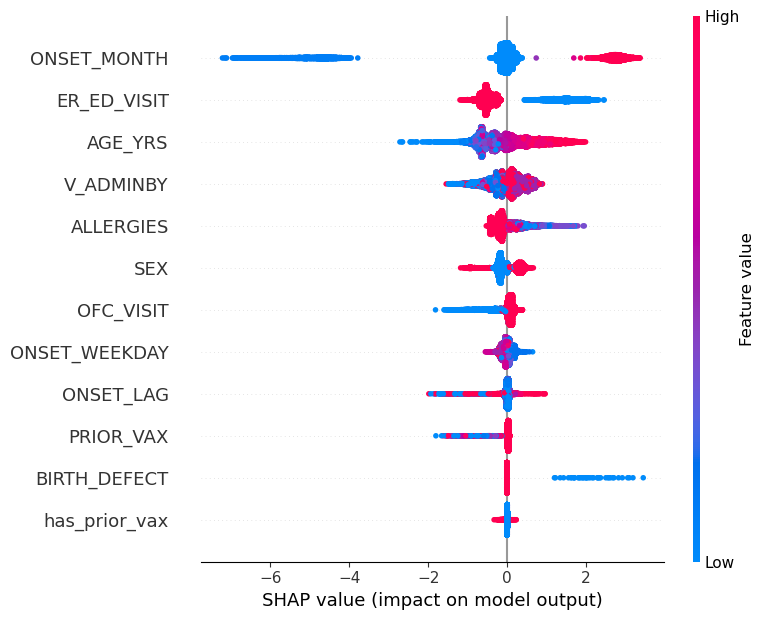

In [16]:
# ----------------------------
# SHAP値の可視化（LightGBMモデル）
# ----------------------------

# explainerの作成（モデルに基づく説明器）
explainer = shap.Explainer(best_lgb_model)

# SHAP値の計算（テストデータに対する寄与度の抽出）
shap_values = explainer(X_test)

# 要約プロット（特徴量ごとの平均的な影響度を可視化）
shap.summary_plot(shap_values, X_test)

モデルに最も影響を与えた特徴量は「ONSET_MONTH（発症月）」であり、特に月の値が高い（12月など冬季）ほど、入院の可能性が高まる傾向が見られた。次いで影響が大きかった「ER_ED_VISIT（救急処置室での受診経験）」では、受診していない場合に入院リスクが高くなることが示唆された。「AGE_YRS（年齢）」については、高齢になるほど入院の可能性がやや上昇する傾向が読み取れる。

## 4.結論とビジネス的示唆

本分析では、ワクチン接種後の入院リスクを定量的に把握することを目的に、入院日数の回帰予測と入院有無の分類モデルを構築・比較した。  
回帰モデルでは、RandomForestおよびLightGBMを用いて最適化を行ったが、いずれのモデルもR²が0.05未満と低く、実用レベルの精度には至らなかった。要因としては、入院日数の分布が大きく偏っていることや、入院日数に強く影響するであろう既往歴・病態・社会的背景などの情報が欠けていたことが考えられる。  
一方、入院の有無を予測する分類モデルでは、F1スコアが0.83、Recallが0.83と高い性能を示し、実用性の高い予測が可能であることが示された。SHAPによる要因分析の結果、ONSET_LAG（発症までの期間）、ER_ED_VISIT（救急受診）、AGE_YRS（年齢）が入院の判断に特に強い影響を与えていることが明らかとなった。  
本モデルのビジネス的示唆としては、病院におけるベッド稼働率の予測と調整、人員・物資（薬・食事等）の事前手配、さらには入院の必要性判断を補助する意思決定支援ツールとしての活用が期待される。  
今後の分析展開としては、患者の既往歴や基礎疾患、介護状況や居住形態といった社会的要因を加味することで、入院日数予測の精度向上が期待できると考えられる。